In [1]:
import json 
import torch 
import numpy as np 

In [2]:
def recursive_to_tensor(obj):
    if isinstance(obj, dict):
        return {k: recursive_to_tensor(v) for k, v in obj.items()} 
    return obj

In [3]:

name = "./results/cifar_10/org_50.json"

# def serializable_to_tensor(obj):
#     # 检测到列表时尝试转为numpy数组，再转Tensor 
#     if isinstance(obj, list):
#         return torch.from_numpy(np.array(obj)) 
#     return obj 
 
with open(name, 'r', encoding='utf-8') as f:
    loaded_data = recursive_to_tensor(json.load(f)) 

In [4]:
def save_fig(fig, name):
    fig.savefig( 
        './tex/images/' + name + '.pdf', 
        format='pdf',
        dpi=600,          # 期刊通常要求300-600dpi 
        bbox_inches='tight',        # 去除多余白边 
        pad_inches=0.05,            # 保留最小边距
        facecolor='white',
        metadata={
            'Author': 'Zongyuan Sui',
            'Creator': 'Python Matplotlib'
        }
    )

def save_fig_3d(fig, name):
    fig.savefig( 
        './tex/images/' + name + '.pdf', 
        format='pdf',
        dpi=600,                    # 期刊通常要求300-600dpi 
        bbox_inches='tight',        # 去除多余白边 
        pad_inches=0.1,            # 保留最小边距
        facecolor='white',
        metadata={
            'Author': 'Zongyuan Sui',
            'Creator': 'Python Matplotlib'
        }
    )

In [5]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation  import FuncAnimation
import matplotlib as mpl
%matplotlib widget 
print("当前后端:", matplotlib.get_backend())   # 应显示module://ipympl.backend_nbagg

import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from optimizers import *
from upanets import UPANets
from torchsummary import summary
import copy
from types import SimpleNamespace 
from train import *

当前后端: module://ipympl.backend_nbagg


In [6]:
mpl.rcParams.update({ 
    'font.family':  'Times New Roman',
    'mathtext.fontset':  'stix',  # 数学符号风格 
    'figure.dpi':  600,
    'pdf.fonttype':  42,          # 嵌入Type1字体
    'ps.fonttype':  42,
    'axes.titlesize':  11,        # 标题字号
    'axes.labelsize':  10,        # 坐标轴字号 
    'legend.fontsize':  9,        # 图例字号 
    'savefig.transparent':  False # 禁用透明背景 
})
plt.rcParams.update({ 
    'figure.titlesize':  11,
    'axes.titlesize':  9,  # 子图标题 
    'axes.titlepad':  10   # 标题与轴间距 
})

In [7]:
args = SimpleNamespace(
    datasets='cifar_10',
    batch_size = 500,
    seed = 42,
    lr=0.1, 
    momentum=0.9,
    wd = 0.0005,
    blocks = 1,
    filters = 16,
    epochs = 400,
    start_epochs = 8
    )
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = 32 # default image size for Cifar-10
im_dimention = 32
cifar_10_mean = [0.4914, 0.4822, 0.4465] 
cifar_10_std = [0.2023, 0.1994, 0.2010]
cifar_100_mean = [0.5071, 0.4867, 0.4408]
cifar_100_std = [0.2673, 0.2564, 0.2762]

data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
    ]),
}

testset = torchvision.datasets.CIFAR10(
    root='./data/cifar_10', train=False, download=True, transform=data_transforms['test'])
testloader = torch.utils.data.DataLoader(
    testset, batch_size=args.batch_size, shuffle=False, num_workers=0)
Num_class = 10

In [8]:
@torch.no_grad()
def get_model_directions(model:nn.Module):
    dirs = torch.stack([
                (pa/pa.norm(p=2))
                for pa in model.parameters()
                  if pa.requires_grad
                ])
    return dirs

@torch.no_grad()
def get_random_directions(model:nn.Module):
    weights = [w for w in model.parameters() if w.requires_grad]
    random_dirs = [torch.randn(w.size()).to(w) for w in weights]
    rd_norms = [rd.mul_(w.norm()/(rd.norm() + 1e-10)) for rd, w in zip(random_dirs, weights)]
    return rd_norms

def perturbate_weights(weights, trainable_weights, x_dir, y_dir, x_step, y_step, scale):
    changes = [dx*x_step + dy*y_step for (dx, dy) in zip(x_dir, y_dir)]
    for i in range(len(trainable_weights)):
        trainable_weights[i].data  = weights[i] + scale * changes[i].to(weights[i])


def calculate_perturbation_loss(model, weights, trainable_weights, x_dir, y_dir, x_step, y_step, scale, x, y, Z, imgs, labels, criterion):
    model.eval()
    for i in range(len(y)):
        for j in range(len(x)):
            perturbate_weights(weights, trainable_weights, x_dir, y_dir, x_step * x[j], y_step * y[i], scale)
            with torch.no_grad():
                outputs = model(imgs)
                # _, preds = torch.max(outputs, 1)
                Z[i][j] = criterion(outputs, labels)

first_batch = next(iter(testloader))
img = first_batch[0][:8].to(device)
label = first_batch[1][:8].to(device)

x_cord_min = -100
y_cord_min = -100
x_cord_max = 100
y_cord_max = 100
x_split_num = 201
y_split_num = 201
weight_perturbation_scale = 0.01
x_step = (x_cord_max - x_cord_min)/(x_split_num-1)
y_step = (y_cord_max - y_cord_min)/(y_split_num-1)

x = np.linspace(x_cord_min, x_cord_max, x_split_num)
y = np.linspace(y_cord_min, y_cord_max, y_split_num)
X, Y = np.meshgrid(x,  y)
Z = np.zeros((len(y),len(x))) 

criterion = torch.nn.CrossEntropyLoss()


In [9]:
# model_path = "./model/cifar_10/pugdr_icos2_0.01_400.pth"
# net_benckmark_data1 = torch.load(model_path,  map_location='cpu')
# benckmark_state_dict1 = net_benckmark_data1['model_state_dict'] 
# model = UPANets(args.filters, Num_class, args.blocks, img_size)
# model.load_state_dict(copy.deepcopy(benckmark_state_dict1))
# model.to(device)

# initial_weights = [p.data.clone() for p in model.parameters() if p.requires_grad]
# trainable_weights = [p for p in model.parameters() if p.requires_grad] 
# x_dir = get_random_directions(model)
# y_dir = get_random_directions(model)
# torch.save({
#     'x_dir': x_dir, 
#     'y_dir': y_dir
# }, './model/cifar_10/dirs.pth') 


In [13]:
dirs = torch.load('./model/cifar_10/dirs.pth',  map_location=device) 
x_dir = dirs['x_dir']
y_dir = dirs['y_dir']

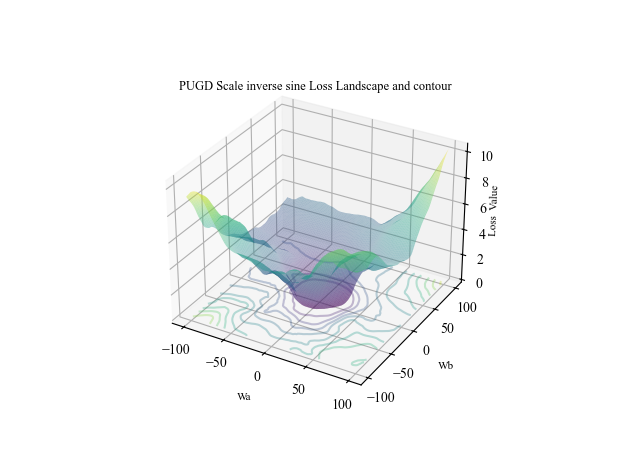

In [14]:
model_path = "./model/cifar_10/pugds_isin3_0.8_400.pth"

net_benckmark_data1 = torch.load(model_path,  map_location='cpu')
benckmark_state_dict1 = net_benckmark_data1['model_state_dict'] 
model = nn.DataParallel(UPANets(args.filters, Num_class, args.blocks, img_size))
# model = UPANets(args.filters, Num_class, args.blocks, img_size)
model.load_state_dict(copy.deepcopy(benckmark_state_dict1))
model.to(device)

initial_weights = [p.data.clone() for p in model.parameters() if p.requires_grad]
trainable_weights = [p for p in model.parameters() if p.requires_grad] 
calculate_perturbation_loss(model, initial_weights, trainable_weights, x_dir, y_dir, x_step, y_step, weight_perturbation_scale, x, y, Z, img, label, criterion)
plt.rcParams['figure.dpi']  = 100
fig = plt.figure(figsize=(16/2.54, 12/2.54))
ax = fig.add_subplot(111,  projection='3d')
ax.set_position([0, 0, 1, 1]) 
# 绘制半透明损失曲面 
surf = ax.plot_surface(X,  Y, Z, cmap='viridis', 
                        alpha=0.4, antialiased=True,
                        rstride=2, cstride=2)

# 添加等高线投影 
ax.contour(X,  Y, Z, 10, zdir='z', offset=Z.min(),  
            cmap='viridis', alpha=0.3)

ax.set_xlabel('Wa', fontsize=8, labelpad=1)
ax.set_ylabel('Wb', fontsize=8, labelpad=1)
# ax.view_init(elev=30,  azim=45)  
ax.set_zlabel('Loss  Value', fontsize=8, labelpad=-8)

ax.tick_params(axis='both',  which='major', pad=0.1) 
plt.tight_layout(pad = 1.0)
plt.title("PUGD Scale inverse sine Loss Landscape and contour",  fontsize=9, y=0.98)
plt.show()
save_fig_3d(fig, "PUGDSISIN_LLC10")
     

In [ ]:
# plt.close('all')   # 关闭所有图形 

In [ ]:
# plt.rcParams['figure.dpi']  = 100
# fig = plt.figure(figsize=(16/2.54, 12/2.54))
# ax = fig.add_subplot(111,  projection='3d')
# ax.set_position([0,  0, 1, 1]) 
# # 绘制半透明损失曲面 
# surf = ax.plot_surface(X, Y, Z, cmap='viridis', 
#                         alpha=0.4, antialiased=True,
#                         rstride=2, cstride=2)

# # 添加等高线投影 
# ax.contour(X,  Y, Z, 10, zdir='z', offset=Z.min(),  
#             cmap='viridis', alpha=0.3)

# ax.set_xlabel('Wa', fontsize=8, labelpad=1)
# ax.set_ylabel('Wb', fontsize=8, labelpad=1)
# # ax.view_init(elev=30,  azim=45)  
# ax.set_zlabel('Loss  Value', fontsize=8, labelpad=-6)

# ax.tick_params(axis='both',  which='major', pad=0.1) 
# plt.tight_layout(pad = 1.0)
# plt.title("SGD Loss Landscape and contour",  fontsize=9, y=0.98)
# plt.show()
# save_fig_3d(fig, "SGD_LLC")


In [ ]:
# from ipywidgets import interact
 
# # Cell 3: 交互控制（单独Cell执行）
# @interact(elev=(0,90,5),  azim=(0,360,5))
# def update(elev=30, azim=45):
#     ax.view_init(elev,  azim)
#     fig.canvas.draw()
    
# display(fig.canvas)

In [ ]:

# # 保存为PNG（透明背景，600dpi高分辨率）
# fig.savefig('3d_surface.png',  dpi=600, transparent=True, bbox_inches='tight')
 
# # 保存为PDF（矢量图，适合论文）
# fig.savefig('3d_surface.pdf',  format='pdf', bbox_inches='tight')
 
# # 保存为SVG（可编辑矢量图）
# fig.savefig('3d_surface.svg',  format='svg')
# # save_html(fig, 'interactive_3d.html') 

In [ ]:
# # 在绘图前释放内存 
# import gc 
# gc.collect()   # 手动触发垃圾回收 
 
# # 使用轻量级后端 
# import matplotlib as mpl 
# mpl.use('TkAgg')   # 默认跨平台后端 
# # mpl.use('Agg')   # 无交互式界面后端 
# %matplotlib inline

# plt.close('all')   # 关闭所有图形 

In [ ]:
# print("当前后端:", matplotlib.get_backend())

In [ ]:
# from IPython import get_ipython 
# get_ipython().kernel.do_shutdown(restart=False, now =False)   # 安全关闭内核，触发清理 